### Proyecto Final Henry "FINDEDEN"
#### Machine Learning: Sistema de puntuación

Autores:

    - Caminos Federico
    - Londero Walter
    - Pizarro Hernan
    - Urteaga Facundo
    - Veron Cintia

In [1]:
# Carga de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

In [3]:
# Cargar el archivo CSV en un DataFrame

df_locales = pd.read_csv("locales_LA.csv")
df_reviews = pd.read_csv("reviews_LA.csv")

#### 1. Forecasting mediante modelo ARIMA

In [6]:
# Contar la cantidad de ocurrencias de cada gmap_id
gmap_counts = df_reviews.groupby('gmap_id').size().reset_index(name='counts')

# Mostrar el resultado
print(gmap_counts)

                                   gmap_id  counts
0    0x14e1b0df6d819dab:0x928b6349b7fbe2f4      30
1    0x80c29b3ff5888f5f:0xb054c9f681f3cdd1      41
2    0x80c2b094b4dba76b:0xa06e6ac61be494f1      45
3    0x80c2b09a1aa56c23:0x7f821110921eff5d     109
4    0x80c2b09b6710f02d:0xf58ccff2da1c8d08      12
..                                     ...     ...
762  0x80c2cfafdbbbf0bd:0x6f94b1db8a8e02d8      16
763  0x80c2cfb41de78d05:0x4dccb1dc807fa83c     117
764  0x80c2cfcb781ef31d:0xfaae6a1f7570db09      40
765  0x80c2db2a056d64dd:0xfea3d8e88ef4203f      10
766  0x80dd49db52626507:0x23710c88621a2079     405

[767 rows x 2 columns]


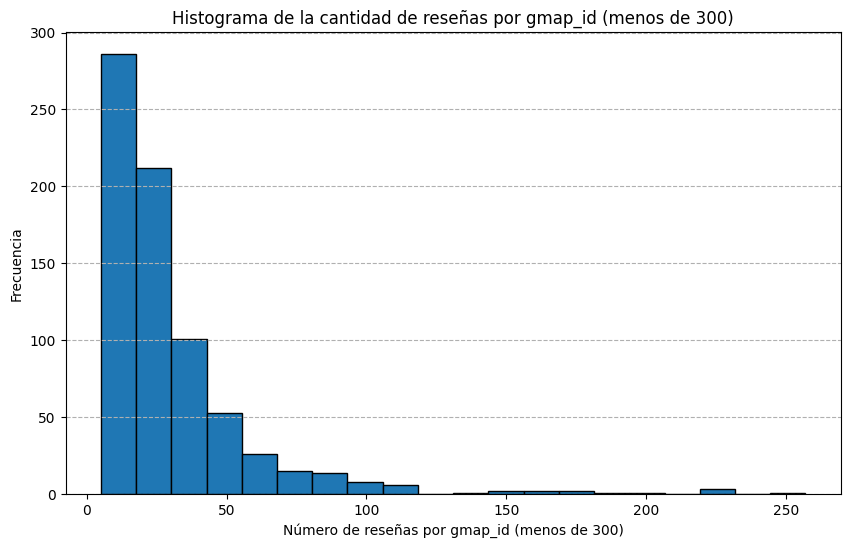

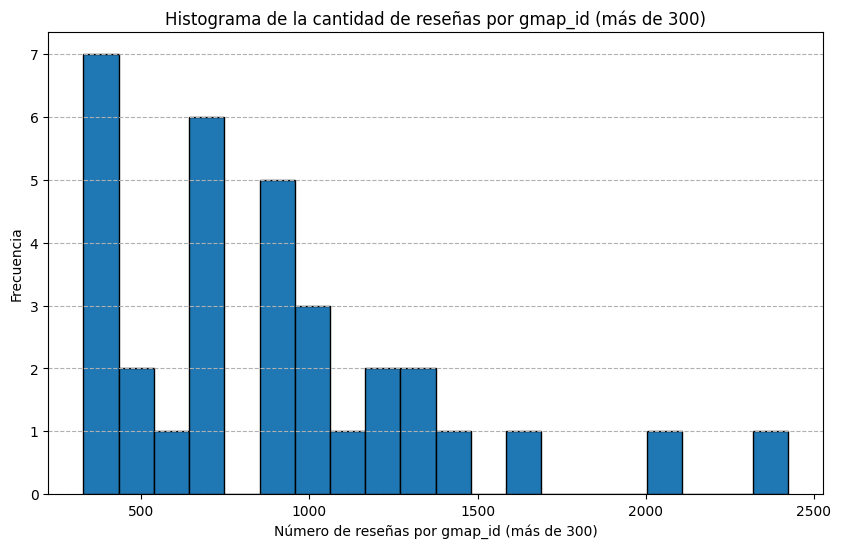

In [13]:
# Filtrar los counts
gmap_counts_less_300 = gmap_counts[gmap_counts['counts'] < 300]
gmap_counts_more_300 = gmap_counts[gmap_counts['counts'] > 300]

# Crear el primer histograma para counts < 300
plt.figure(figsize=(10, 6))
plt.hist(gmap_counts_less_300['counts'], bins=20, edgecolor='black')
plt.xlabel('Número de reseñas por gmap_id (menos de 300)')
plt.ylabel('Frecuencia')
plt.title('Histograma de la cantidad de reseñas por gmap_id (menos de 300)')
plt.grid(axis='y', linestyle='--')

# Mostrar el primer histograma
plt.show()

# Crear el segundo histograma para counts > 300
plt.figure(figsize=(10, 6))
plt.hist(gmap_counts_more_300['counts'], bins=20, edgecolor='black')
plt.xlabel('Número de reseñas por gmap_id (más de 300)')
plt.ylabel('Frecuencia')
plt.title('Histograma de la cantidad de reseñas por gmap_id (más de 300)')
plt.grid(axis='y', linestyle='--')

# Mostrar el segundo histograma
plt.show()

In [14]:
gmap_counts_forecast = gmap_counts[gmap_counts['counts'] > 30]

In [15]:
df_reviews

,user_id,time,rating,gmap_id,date,user_rating,weighted_rating,weight
0,1.089912e+20,1609909927056,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2021-01-06 05:12:07.056,1,5,1
1,1.112903e+20,1612849648663,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2021-02-09 05:47:28.663,1,5,1
2,1.126404e+20,1583643882296,4,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2020-03-08 05:04:42.296,3,12,3
3,1.174403e+20,1551938216355,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2019-03-07 05:56:56.355,3,15,3
4,1.005808e+20,1494910901933,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2017-05-16 05:01:41.933,1,5,1
...,...,...,...,...,...,...,...,...
52402,1.064552e+20,1563494706323,5,0x80c2b82e593589a1:0x35602b6daadce0d7,2019-07-19 00:05:06.323,1,5,1
52403,1.164411e+20,1560529465601,3,0x80c2b82e593589a1:0x35602b6daadce0d7,2019-06-14 16:24:25.601,1,3,1
52404,1.011934e+20,1571624221742,4,0x80c2b82e593589a1:0x35602b6daadce0d7,2019-10-21 02:17:01.742,1,4,1
52405,1.100051e+20,1555389818932,3,0x80c2b82e593589a1:0x35602b6daadce0d7,2019-04-16 04:43:38.932,1,3,1


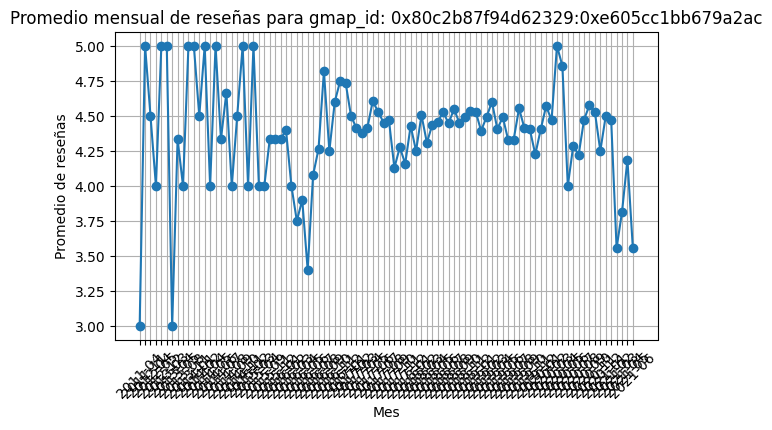

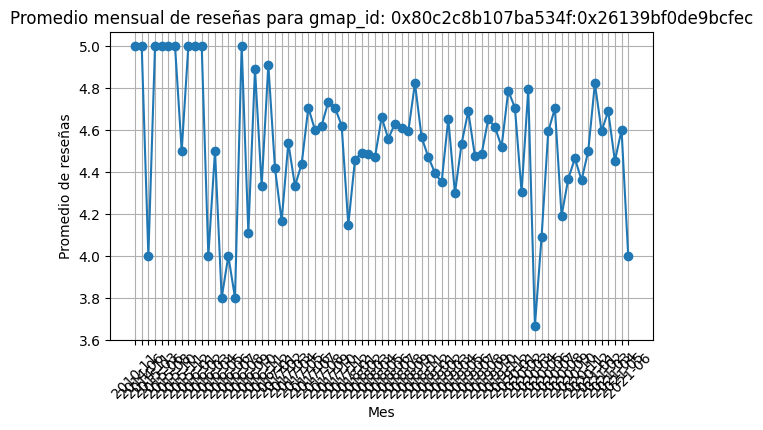

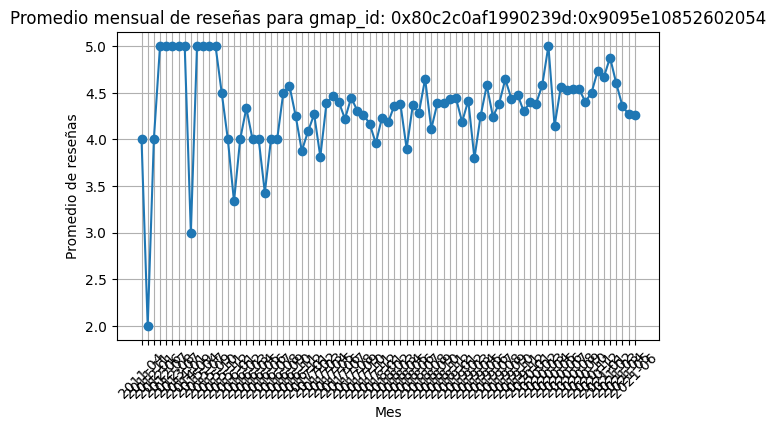

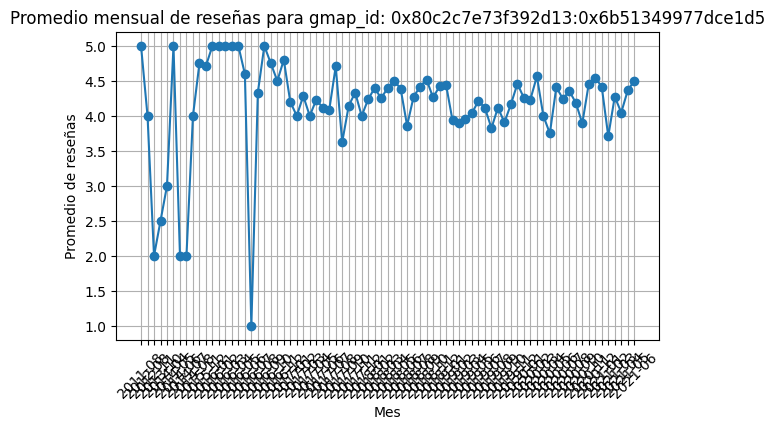

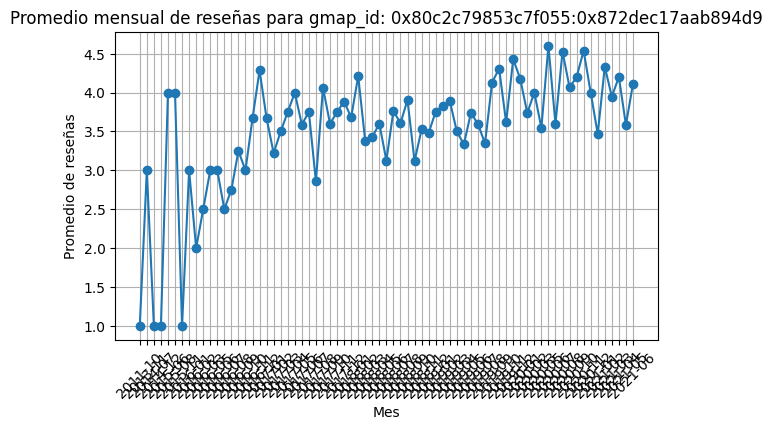

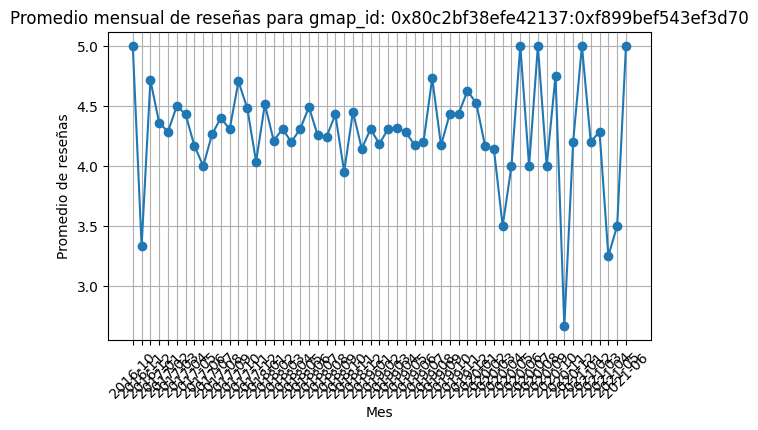

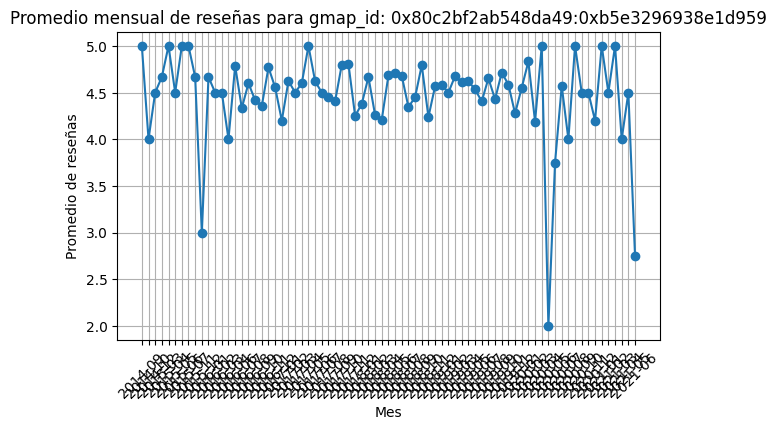

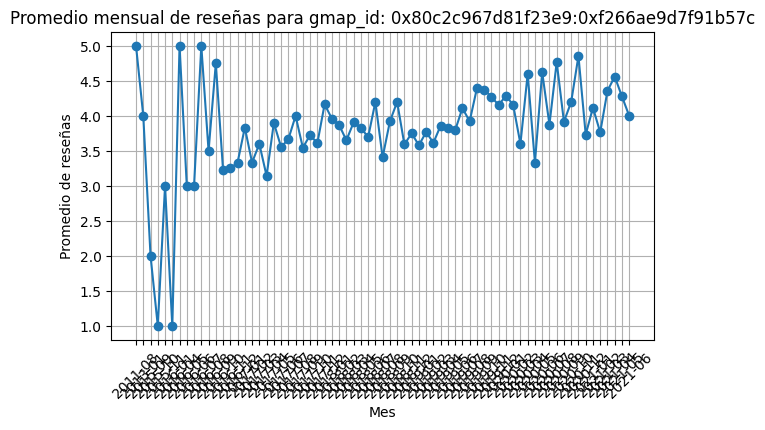

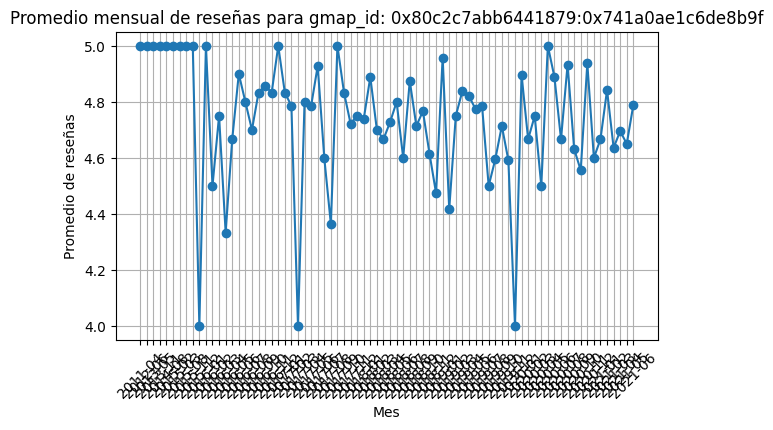

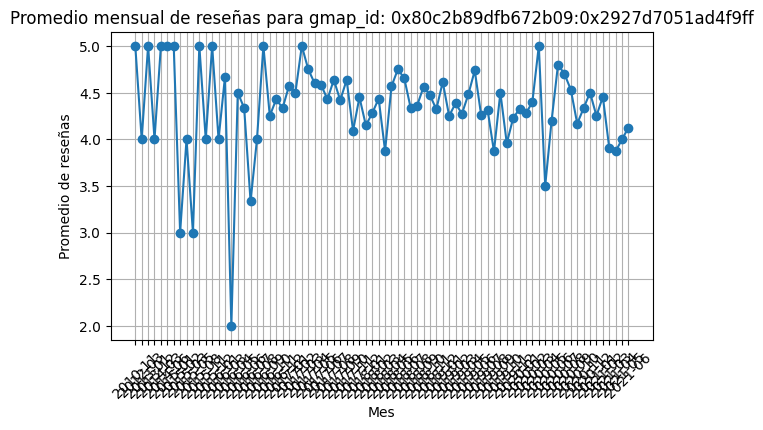

In [19]:
# Filtrar df_reviews para mantener solo los gmap_id que están en gmap_counts_forecast
filtered_reviews = df_reviews[df_reviews['gmap_id'].isin(gmap_counts_forecast['gmap_id'])]

# Verificar si los valores de 'time' están en milisegundos y convertir a segundos si es necesario
if filtered_reviews['time'].max() > 1e12:  # Unix timestamp en milisegundos es mayor que 1e12
    filtered_reviews['time'] = filtered_reviews['time'] / 1000

# Convertir la columna 'time' de formato Unix a datetime
filtered_reviews['time'] = pd.to_datetime(filtered_reviews['time'], unit='s')

# Agrupar por 'gmap_id' y por mes, calcular el promedio de las reseñas
filtered_reviews['month'] = filtered_reviews['time'].dt.to_period('M')
monthly_avg_reviews = filtered_reviews.groupby(['gmap_id', 'month'])['rating'].mean().reset_index()

# Seleccionar los 10 gmap_id con mayor cantidad de reviews
top_10_gmap_ids = gmap_counts_forecast.nlargest(10, 'counts')['gmap_id']

# Filtrar los datos para solo los top 10 gmap_id
top_10_reviews = monthly_avg_reviews[monthly_avg_reviews['gmap_id'].isin(top_10_gmap_ids)]

# Crear gráficos separados para cada uno de los top 10 gmap_id
for gmap_id in top_10_gmap_ids:
    data = top_10_reviews[top_10_reviews['gmap_id'] == gmap_id]
    
    plt.figure(figsize=(7, 4))
    plt.plot(data['month'].astype(str), data['rating'], marker='o')
    
    plt.xlabel('Mes')
    plt.ylabel('Promedio de reseñas')
    plt.title(f'Promedio mensual de reseñas para gmap_id: {gmap_id}')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Mostrar el gráfico para el gmap_id actual
    plt.show()